# Analysis examples

In [1]:
import logging

logger = logging.getLogger("analysis_logger")
logger.setLevel(logging.INFO)

filename = "/Users/wolf/Downloads/Exp2_Camera1_25h.analysis.h5"
# filename = "/Volumes/Seagate Backup  1/lts/Exp2_Camera1_25h.analysis.slp"

In [2]:
import h5py
import numpy as np

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()


===filename===
/Users/wolf/Downloads/Exp2_Camera1_25h.analysis.h5

===HDF5 datasets===
['node_names', 'track_names', 'track_occupancy', 'tracks']

===locations data shape===
(9000000, 14, 2, 4)

===nodes===
0: head
1: eyeL
2: eyeR
3: thorax
4: abdomen
5: forelegL
6: forelegR
7: midlegL
8: midlegR
9: hindlegL
10: hindlegR
11: wingL
12: wingR
13: proboscis



In [3]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

HEAD_INDEX = node_names.index('head')
THORAX_INDEX = node_names.index('thorax')
ABDO_INDEX = node_names.index('abdomen')

frame count: 9000000
node count: 14
instance count: 4


In [4]:
import utils.trx_utils as trx_utils
locations = trx_utils.fill_missing_np(locations)


In [5]:
locations = trx_utils.fill_missing_np(locations)


100%|██████████| 112/112 [01:28<00:00,  1.26it/s]


In [70]:
import importlib
importlib.reload(mmpy)

import glob, os, pickle
from datetime import datetime

import numpy as np
from scipy.io import loadmat,savemat
import hdf5storage
import sys
sys.path.append('/mnt/HFSP_Data/scripts/motionmapperpy')
import utils.motionmapperpy.motionmapperpy as mmpy
projectPath = 'TestProject'
mmpy.createProjectDirectory(projectPath)
for i in range(4):
    data = locations[0:(1*10000),0:13,:,i]
    data = trx_utils.smooth_median(data, window=5)
    vels = trx_utils.instance_node_velocities(data,0,data.shape[0]).astype(np.float32)
    data = trx_utils.normalize_to_egocentric(x=data,ctr_ind=THORAX_INDEX,fwd_ind=HEAD_INDEX)
    # mask = (vels > 3).any(axis=1)
    # data = data[mask,:]
    # data = data[np.random.randint(0,data.shape[0],size=10000),:]
    data =  data.reshape((data.shape[0],2*data.shape[1]))
    print(data.shape)
    savemat('TestProject/Projections/dataset_%i_pcaModes.mat'%(i+1), {'projections':data})

parameters = mmpy.setRunParameters()

# %%%%%%% PARAMETERS TO CHANGE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
parameters.projectPath = projectPath
parameters.method = 'TSNE'

parameters.waveletDecomp = True #% Whether to do wavelet decomposition. If False, PCA projections are used for
                                #% tSNE embedding.

parameters.minF = 0.5 #% Minimum frequency for Morlet Wavelet Transform

parameters.maxF = 25                   #% Maximum frequency for Morlet Wavelet Transform,
                                        #% equal to Nyquist frequency for your measurements.

# parameters.perplexity = 5
# parameters.training_perplexity = 20

parameters.samplingFreq = 20            #% Sampling frequency (or FPS) of data.

parameters.numPeriods = 25               #% No. of frequencies between minF and maxF.

parameters.numProcessors = -1          #% No. of processor to use when parallel
                                        #% processing (for wavelets, if not using GPU). -1 to use all cores.

parameters.useGPU = -1                   # GPU to use, set to -1 if GPU not present

parameters.training_numPoints=1000      #% Number of points in mini-tSNEs.

# %%%%% NO NEED TO CHANGE THESE UNLESS RAM (NOT GPU) MEMORY ERRORS RAISED%%%%%%%%%%
parameters.trainingSetSize=3000        #% Total number of representative points to find. Increase or decrease based on
                                        #% available RAM. For reference, 36k is a good number with 64GB RAM.

parameters.embedding_batchSize = 30000  #% Lower this if you get a memory error when re-embedding points on learned
                                        #% tSNE map.


projectionFiles = glob.glob(parameters.projectPath+'/Projections/*pcaModes.mat')
for i in projectionFiles:
    print(i)

m = loadmat(projectionFiles[0], variable_names=['projections'])['projections']

# %%%%%
parameters.pcaModes = m.shape[1] #%Number of PCA projections in saved files.
parameters.numProjections = parameters.pcaModes
# %%%%%
del m

print(datetime.now().strftime('%m-%d-%Y_%H-%M'))
print('tsneStarted')

if parameters.method == 'TSNE':
    if parameters.waveletDecomp:
        tsnefolder = parameters.projectPath+'/TSNE/'
    else:
        tsnefolder = parameters.projectPath + '/TSNE_Projections/'
elif parameters.method == 'UMAP':
    tsnefolder = parameters.projectPath+'/UMAP/'

if not os.path.exists(tsnefolder +'training_tsne_embedding.mat'):
    print('Running minitSNE')
    mmpy.subsampled_tsne_from_projections(parameters, parameters.projectPath)
    print('minitSNE done, finding embeddings now.')
    print(datetime.now().strftime('%m-%d-%Y_%H-%M'))

import h5py
with h5py.File(tsnefolder + 'training_data.mat', 'r') as hfile:
    trainingSetData = hfile['trainingSetData'][:].T

with h5py.File(tsnefolder+ 'training_embedding.mat', 'r') as hfile:
    trainingEmbedding= hfile['trainingEmbedding'][:].T

if parameters.method == 'TSNE':
    zValstr = 'zVals' if parameters.waveletDecomp else 'zValsProjs'
else:
    zValstr = 'uVals'

for i in range(len(projectionFiles)):
    print('Finding Embeddings')
    print('%i/%i : %s'%(i+1,len(projectionFiles), projectionFiles[i]))
    if os.path.exists(projectionFiles[i][:-4] +'_%s.mat'%(zValstr)):
        print('Already done. Skipping.\n')
        continue


    projections = loadmat(projectionFiles[i])['projections']
    zValues, outputStatistics = mmpy.findEmbeddings(projections,trainingSetData,trainingEmbedding,parameters)

    hdf5storage.write(data = {'zValues':zValues}, path = '/', truncate_existing = True,
                    filename = projectionFiles[i][:-4]+'_%s.mat'%(zValstr), store_python_metadata = False,
                      matlab_compatible = True)
    with open(projectionFiles[i][:-4] + '_%s_outputStatistics.pkl'%(zValstr), 'wb') as hfile:
        pickle.dump(outputStatistics, hfile)

    print('Embeddings saved.\n')
    del zValues,projections,outputStatistics

print('All Embeddings Saved!')

mmpy.findWatershedRegions(parameters, minimum_regions=10, startsigma=0.3, pThreshold=[0.33, 0.67],
                     saveplot=True, endident = '*_pcaModes.mat')

Skipping, path already exists : TestProject
Skipping, path already exists : TestProject/Projections
Skipping, path already exists : TestProject/TSNE_Projections
Skipping, path already exists : TestProject/TSNE
Skipping, path already exists : TestProject/UMAP
(10000, 26)
(10000, 26)
(10000, 26)
(10000, 26)
TestProject/Projections/dataset_1_pcaModes.mat
TestProject/Projections/dataset_3_pcaModes.mat
TestProject/Projections/dataset_4_pcaModes.mat
TestProject/Projections/dataset_5_pcaModes.mat
TestProject/Projections/dataset_2_pcaModes.mat
11-03-2021_19-04
tsneStarted
Running minitSNE
Finding Training Set
Subsampled trainingSetData found, skipping minitSNE and running training tSNE
Finding t-SNE Embedding for Training Set
Finding Distances


/Users/wolf/git/long-timescale-behavior/analysis/utils/motionmapperpy/motionmapperpy/motionmapper.py:30: RuntimeWarning: divide by zero encountered in log
  logData = np.log(data)
/Users/wolf/opt/anaconda3/envs/long-timescale-behavior/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


Computing t-SNE
[t-SNE] Computing 97 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.014s...
[t-SNE] Computed neighbors for 3000 samples in 0.105s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.269265
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.527847
[t-SNE] KL divergence after 1000 iterations: 1.038885
minitSNE done, finding embeddings now.
11-03-2021_19-04
Finding Embeddings
1/5 : TestProject/Projections/dataset_1_pcaModes.mat
Finding Wavelets
	 Calculating wavelets, clock starting.
	 Using #16 CPUs.
	 Done at 1.33 seconds.
Finding Embeddings
	 Processing batch #   1 out of    1
Zeros found in wavelet data at following positions. Will replace then with 1e-12.
	 Calculating distances for batch    1


/Users/wolf/git/long-timescale-behavior/analysis/utils/motionmapperpy/motionmapperpy/motionmapper.py:447: RuntimeWarning: divide by zero encountered in log
  logData2 = np.log(data2)


	 Calculated distances for batch    1 0.75seconds.
	 Calculating fminProjections for batch    1


/Users/wolf/git/long-timescale-behavior/analysis/utils/motionmapperpy/motionmapperpy/motionmapper.py:401: RuntimeWarning: invalid value encountered in true_divide
  p = np.exp(-0.5*np.square(ds)/sigma**2)
/Users/wolf/git/long-timescale-behavior/analysis/utils/motionmapperpy/motionmapperpy/motionmapper.py:403: RuntimeWarning: invalid value encountered in greater
  idx = p>0
/Users/wolf/git/long-timescale-behavior/analysis/utils/motionmapperpy/motionmapperpy/motionmapper.py:401: RuntimeWarning: invalid value encountered in true_divide
  p = np.exp(-0.5*np.square(ds)/sigma**2)
/Users/wolf/git/long-timescale-behavior/analysis/utils/motionmapperpy/motionmapperpy/motionmapper.py:403: RuntimeWarning: invalid value encountered in greater
  idx = p>0
/Users/wolf/git/long-timescale-behavior/analysis/utils/motionmapperpy/motionmapperpy/motionmapper.py:401: RuntimeWarning: invalid value encountered in true_divide
  p = np.exp(-0.5*np.square(ds)/sigma**2)
/Users/wolf/git/long-timescale-behavior/ana

ValueError: Starting sigma is inf, highGuess is inf and lowGuess is 0.00

In [30]:
# data, _ = mmpy.findWavelets(data, 1, parameters)
data, _ = mmpy.findWavelets(data[0,:], 1, parameters.omega0, parameters.numPeriods, parameters.samplingFreq, parameters.maxF, parameters.minF, parameters.numProcessors, parameters.useGPU)

	 Calculating wavelets, clock starting.
	 Using #16 CPUs.
	 Done at 0.27 seconds.


In [44]:
data.shape

(10000, 26)

In [56]:
data, _ = mmpy.mm_findWavelets(data, 1, parameters)

3

In [17]:
import matplotlib.pyplot as plt
i=1
data = locations[0:(1*359856),0:13,:,i]
data = trx_utils.smooth_median(data, window=5)
vels = trx_utils.instance_node_velocities(data,0,data.shape[0],data.shape[0]).astype(np.float32)
data = trx_utils.normalize_to_egocentric(x=data,ctr_ind=THORAX_INDEX,fwd_ind=HEAD_INDEX)
mask = (vels > 5).any(axis=1)
data = data[mask,:]
data = data[np.random.randint(0,data.shape[0],size=1000),:]
reshaped = data.reshape((data.shape[0],2*data.shape[1]))
print(data.shape)
print(vels.shape)
vels[np.isnan(vels)]



(10000, 13, 2)
(359856, 13)


<Figure size 640x480 with 0 Axes>

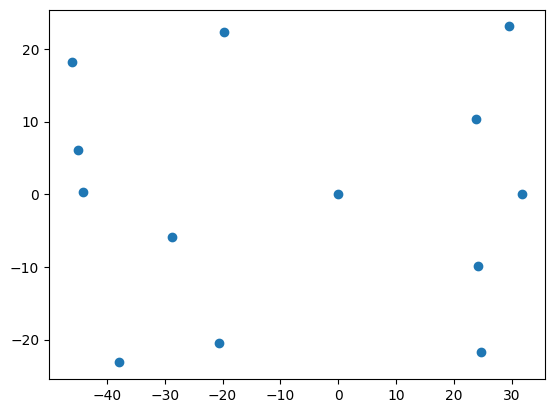

In [26]:
plt.scatter(x = data[0,0,0],y=data[0,:,1])
plt.show()

In [123]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(data)
plt.show()

In [122]:
plt.plot(np.linspace(10,50))
plt.show()

In [93]:
vels[np.isnan(vels)]

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [48]:
projs = projs[~np.isnan(projs)]
projs

array([0.0024235 , 0.09123569, 0.00595146, ..., 0.00956731, 0.00590366,
       0.00905814], dtype=float32)

## Visualize thorax movement across video

In [69]:
HEAD_INDEX = node_names.index('head')
THORAX_INDEX = node_names.index('thorax')
ABDO_INDEX = node_names.index('abdomen')

head_loc = locations[:, HEAD_INDEX, :, :]
thorax_loc = locations[:, THORAX_INDEX, :, :]
abdo_loc = locations[:, ABDO_INDEX, :, :]

In [98]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import palettable

In [99]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


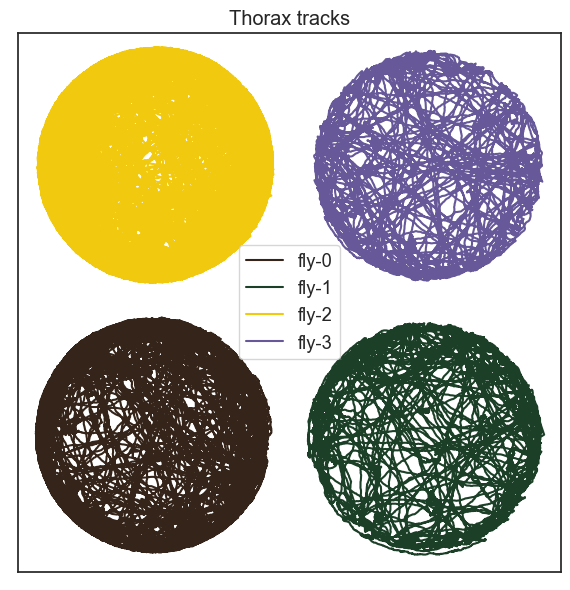

In [12]:
# plt.figure()
# plt.plot(thorax_loc[:,0,0], 'y',label='fly-0')
# plt.plot(thorax_loc[:,0,1], 'g',label='fly-1')
from matplotlib.colors import ListedColormap
# cmap = ListedColormap(palettable.wesanderson.Aquatic1_5.mpl_colors)
# print(lcmap)
# plt.plot(-1*thorax_loc[:,1,0], 'y')
# plt.plot(-1*thorax_loc[:,1,1], 'g')

# plt.legend(loc="center right")
# plt.title('Thorax locations')

plt.figure(figsize=(7,7))
for i in tqdm(range(0,4)):
    plt.plot(thorax_loc[:,0,i],thorax_loc[:,1,i], 'y',label=f'fly-{i}',color=palettable.wesanderson.Aquatic1_5.mpl_colors[i]);
# plt.plot(thorax_loc[:,0,1],thorax_loc[:,1,1], 'g',label='fly-1')
plt.legend(loc=10)

plt.xlim(0,1536)
plt.xticks([])

plt.ylim(0,1536)
plt.yticks([])
plt.title('Thorax tracks')
plt.show()

/Users/wolf/opt/anaconda3/envs/long-timescale-behavior/lib/python3.7/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/Users/wolf/opt/anaconda3/envs/long-timescale-behavior/lib/python3.7/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/Users/wolf/opt/anaconda3/envs/long-timescale-behavior/lib/python3.7/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/Users/wolf/opt/anaconda3/envs/long-timescale-behavior/lib/python3.7/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thres

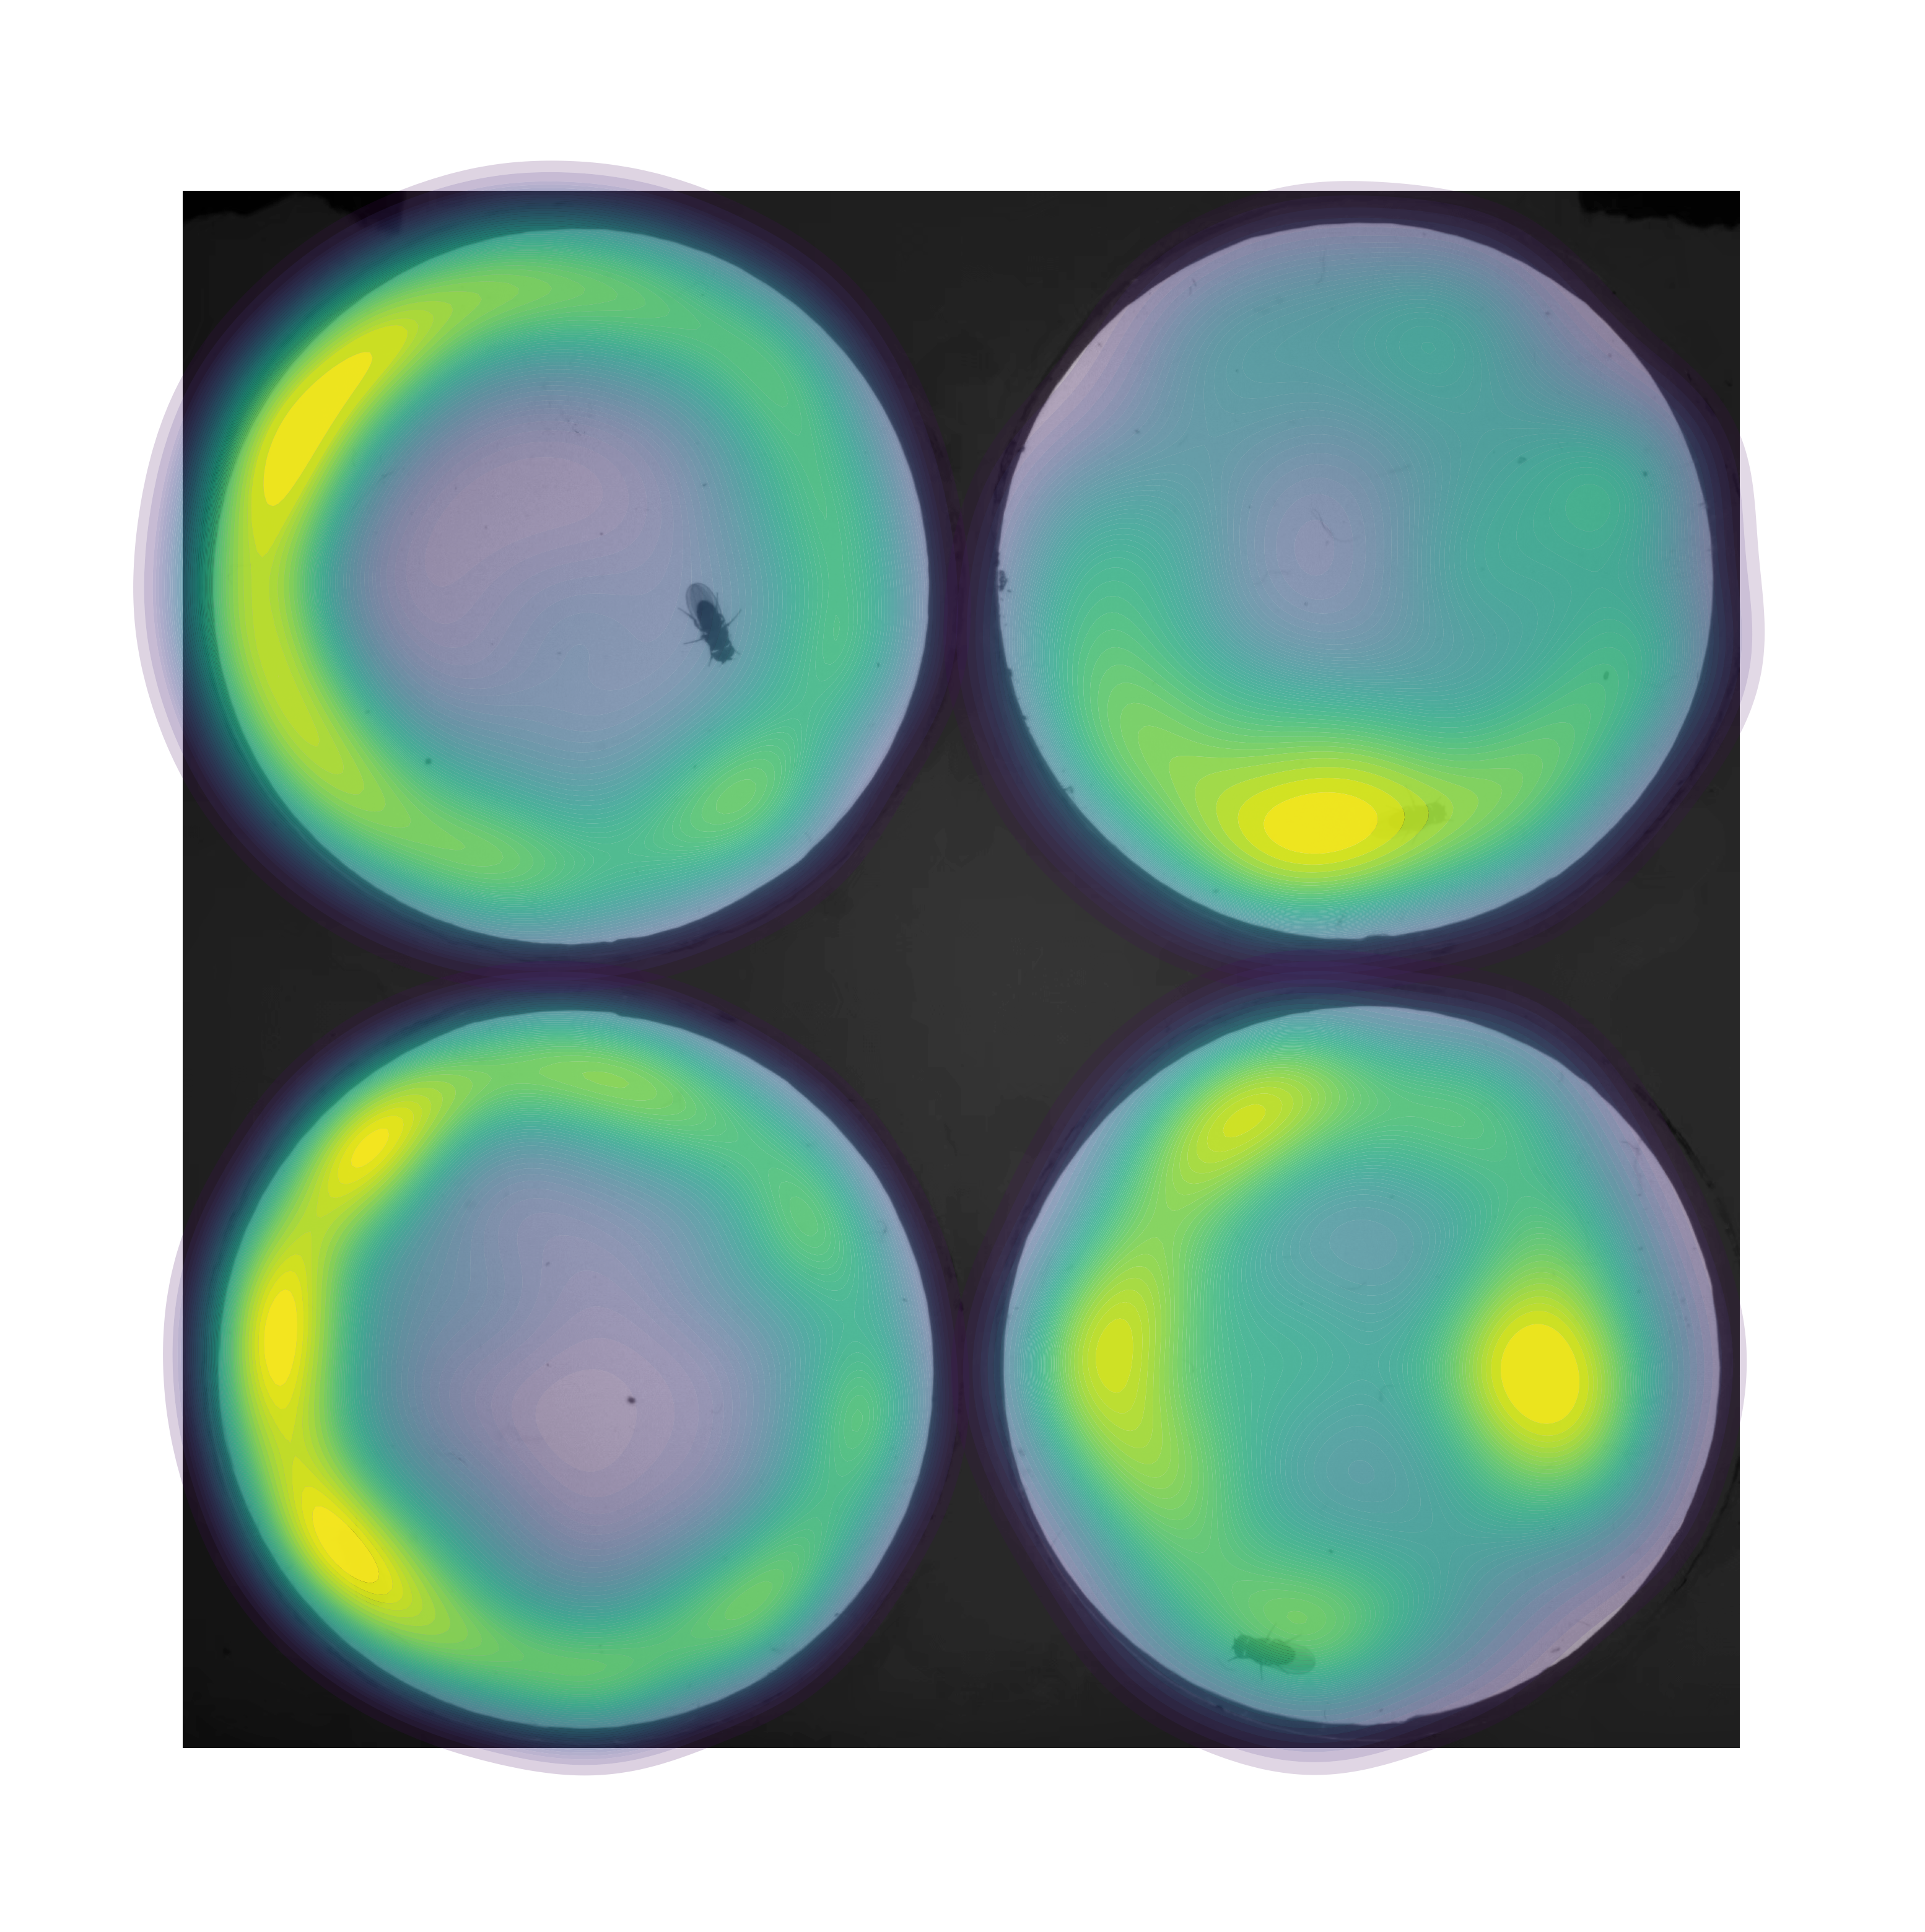

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
import matplotlib.colors as cols
from cv2 import cv2
fig, ax = plt.subplots();
cmap = palettable.matplotlib.Viridis_20.get_mpl_colormap()
# cmap.set_bad("white")
ax.set_aspect('equal')
def alpha_cmap(cmap):
    my_cmap = cmap(np.arange(cmap.N))
    # Set a square root alpha.
    x = np.linspace(0, 1, cmap.N)
    my_cmap[:,-1] = x ** (0.5)
    my_cmap = cols.ListedColormap(my_cmap)

    return my_cmap
cap = cv2.VideoCapture("/Users/wolf/git/motionmapperpy/merged_25h.mp4")
res, frame = cap.read()
frame = frame[:,:,0]
plt.imshow(frame,cmap='gray');
for fly_idx in range(4):
    data = thorax_loc[thx_vel[fly_idx] > 1,:,fly_idx]
    data = data[::100]
    x, y = data.T
    # nbins = 175
    # k = kde.gaussian_kde(data.T)
    # xi, yi = np.mgrid[x.min()-100:x.max()+100:nbins*1j, y.min()-100:y.max()+100:nbins*1j]
    # zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    kplot = sns.kdeplot(x=x, y=y,
                    ax=ax,
                    cmap=alpha_cmap(plt.cm.viridis),
                    shade=True,
                    shade_lowest=False,
                    n_levels=50,
                    # bw=.2,
                    antialiased=True)

    # zi[zi < 0.0000001] = np.nan




    # ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', alpha = .5)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_aspect('equal')
# ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
fig.set_size_inches(5, 5, True);
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
fig.patch.set_visible(False)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
plt.show()

In [103]:
thx_vel = [smooth_diff(thorax_loc[:, :, fly_idx]) for fly_idx in range(4)]

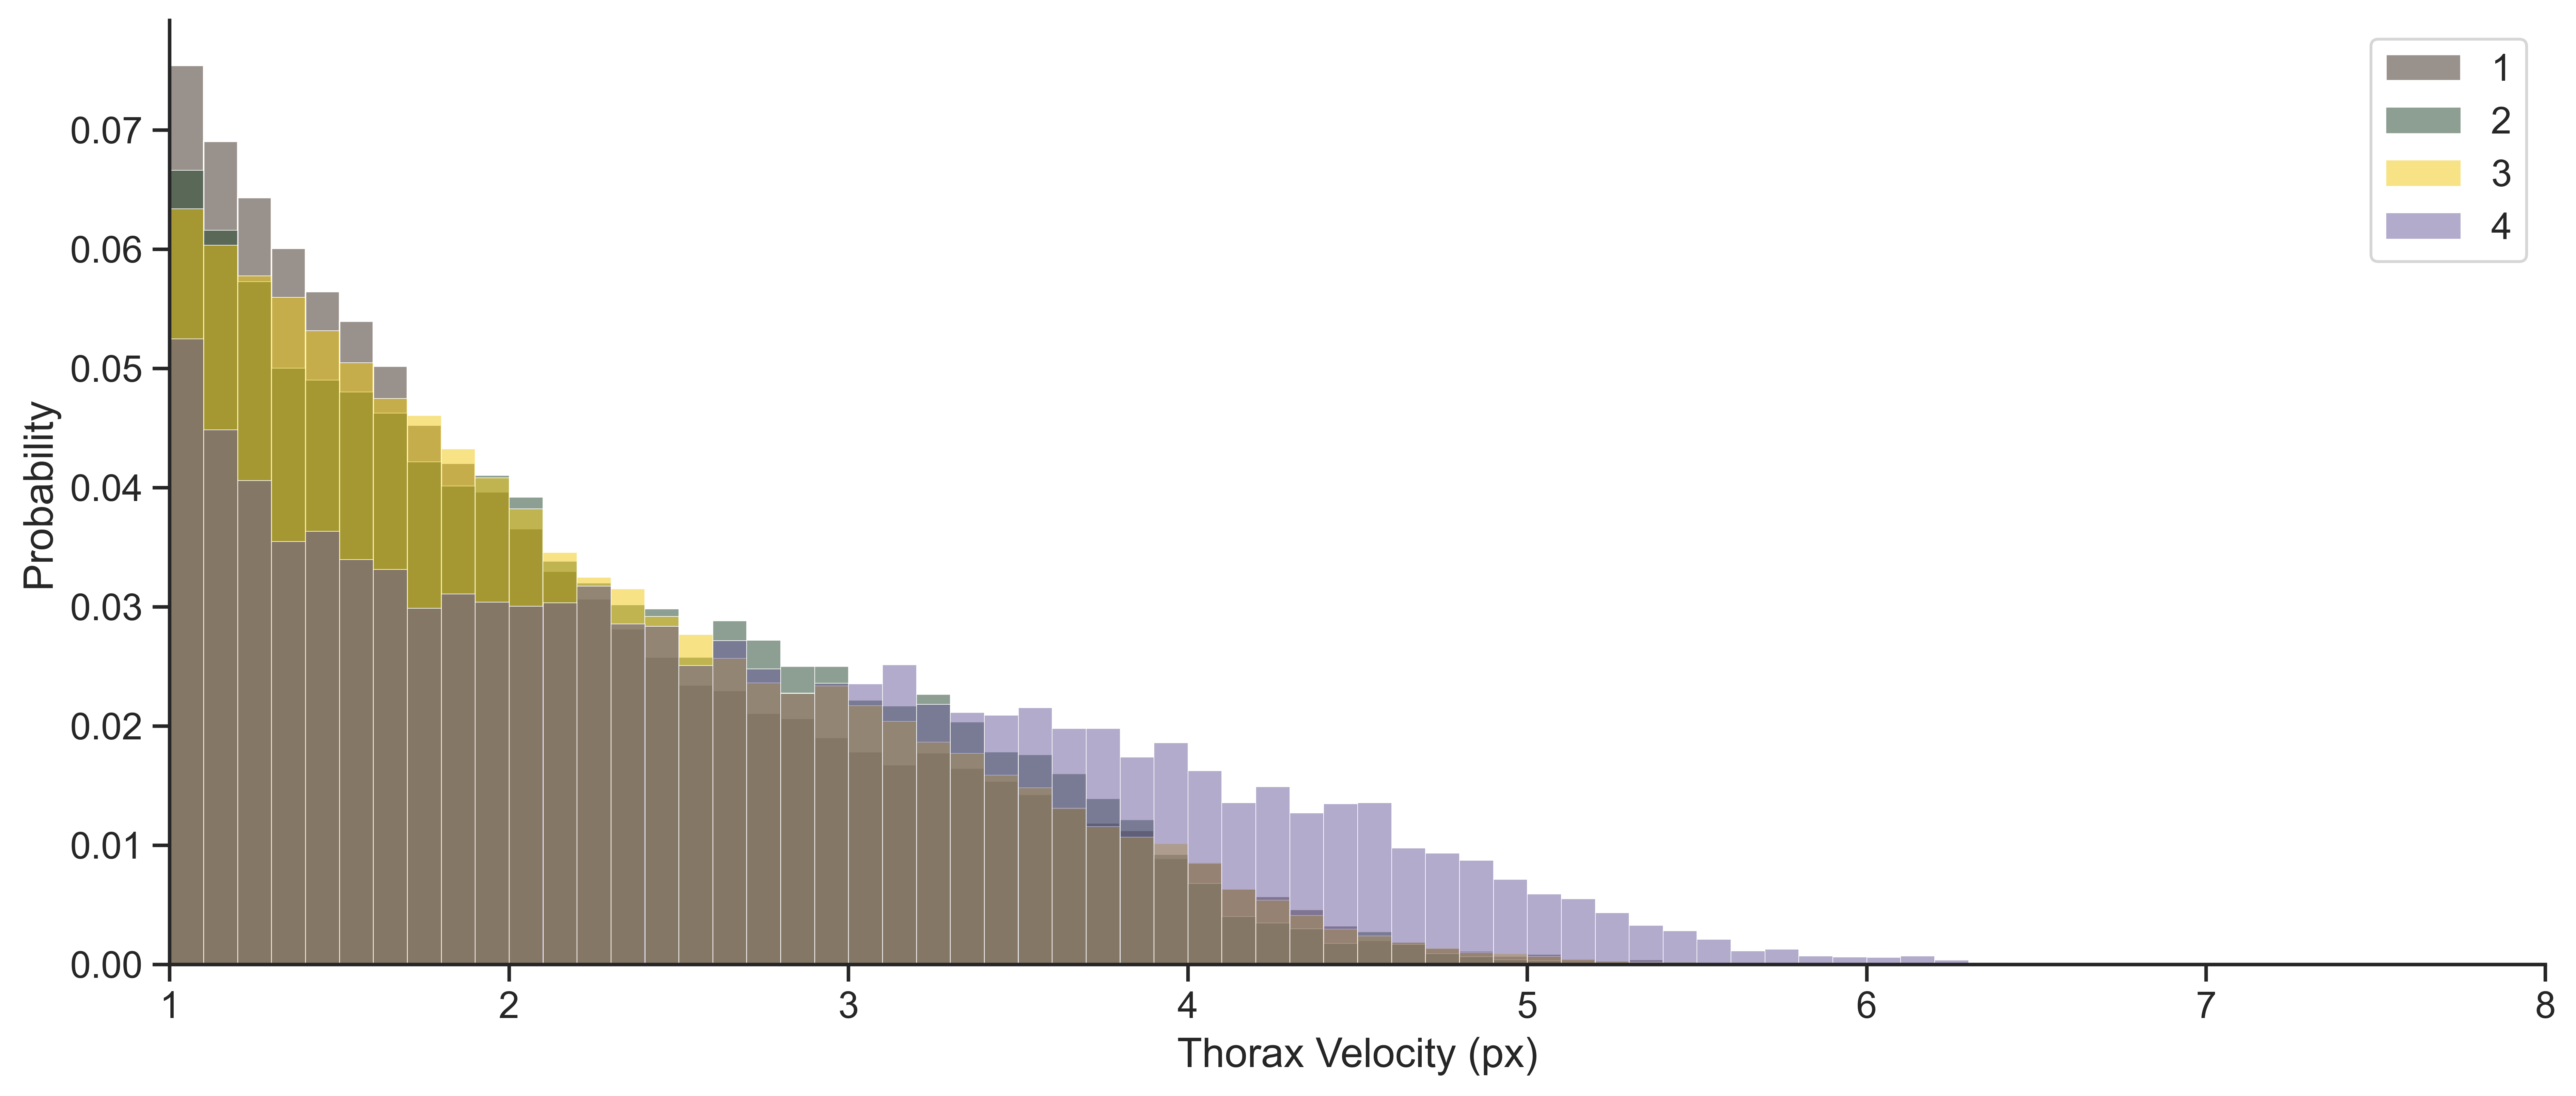

In [143]:
mpl.rcParams['figure.dpi'] =600
fig, ax = plt.subplots()
for i in range(4):
    sns.histplot(thx_vel[i][thx_vel[i] > 1],bins=100,stat="probability",binwidth=.1,alpha = .5, color=palettable.wesanderson.Aquatic1_5.mpl_colors[i])
plt.legend(labels=['1',"2", "3","4"])
plt.xlabel("Thorax Velocity (px)")
plt.xlim(1,8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [48]:
thx_vel_fly = smooth_diff(thorax_loc[:, :, fly_idx])

NameError: name 'smooth_diff' is not defined

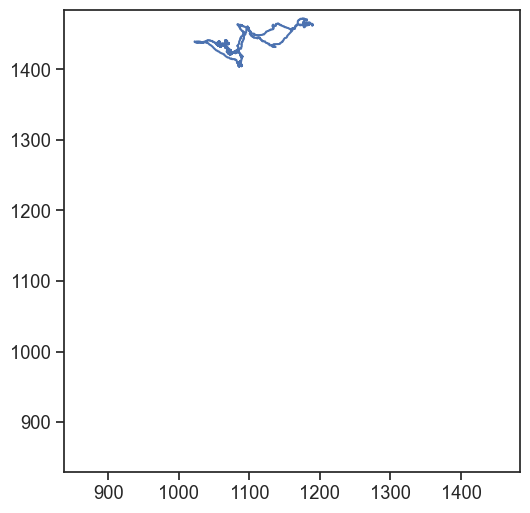

In [49]:
thorax_x = thorax_loc[:,0,fly_idx]
thorax_y = thorax_loc[:,1,fly_idx]
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(thorax_x[0:300000],thorax_y[0:300000]);
plt.xlim(thorax_x.min(),thorax_x.max())
plt.ylim(thorax_y.min(),thorax_y.max())
plt.show()

Saving frame 200
Saving frame 200
Saving frame 200
Saving frame 200
Saving frame 200
Saving frame 200
Saving frame 200
Saving frame 200
Saving frame 201
Saving frame 201
Saving frame 201
Saving frame 201
Saving frame 202
Saving frame 202
Saving frame 202
Saving frame 202
Saving frame 203
Saving frame 203
Saving frame 203
Saving frame 203
Saving frame 204
Saving frame 204
Saving frame 204
Saving frame 204
Saving frame 205
Saving frame 205
Saving frame 205
Saving frame 205
Saving frame 206
Saving frame 206
Saving frame 206
Saving frame 206
Saving frame 207
Saving frame 207
Saving frame 207
Saving frame 207
Saving frame 208
Saving frame 208
Saving frame 208
Saving frame 208
Saving frame 209
Saving frame 209
Saving frame 209
Saving frame 209
Saving frame 210
Saving frame 210
Saving frame 210
Saving frame 210
Saving frame 211
Saving frame 211
Saving frame 211
Saving frame 211
Saving frame 212
Saving frame 212
Saving frame 212
Saving frame 212
Saving frame 213
Saving frame 213
Saving frame 2

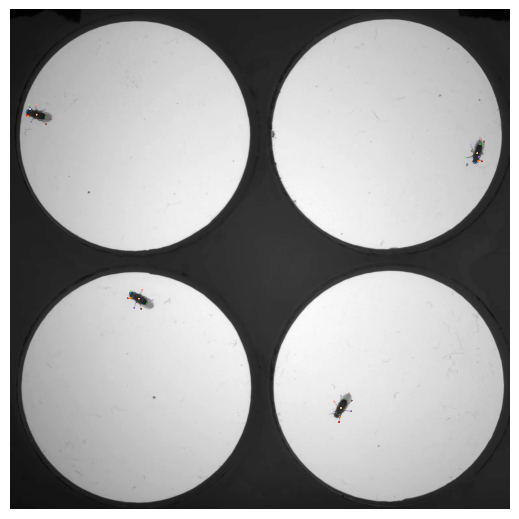

In [88]:
# %matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
from cv2 import cv2
from matplotlib.animation import FuncAnimation
import palettable

# cap = cv2.VideoCapture("/Users/wolf/git/motionmapperpy/merged_25h.mp4")



# xlims = [np.nanmin(data[:,:,0]), np.nanmax(data[:,:,0])]
# ylims = [np.nanmin(data[:,:,1]), np.nanmax(data[:,:,1])]


def animate(i):
    plt.cla();
    for fly_idx in range(4):
        data = locations[7900000:7901000,0:13,:,fly_idx]
        data = trx_utils.smooth_median(data)
        data = trx_utils.smooth_gaussian(data)
        data[data == 0] = np.nan
        frame_numbers = list(range(1000))
        trail_length = 25
        frame_idx = frame_numbers[i] + 25
        # plt.xlim(xlims);
        # plt.ylim(ylims);
        ax.axis('off')
        ax.set_axis_off()
        fig.add_axes(ax)
        fig.patch.set_visible(False)
        print(f'Saving frame {i}')
        data_subset = data[(frame_idx - trail_length):frame_idx]
        for node_idx in range(0,data_subset.shape[1])[:-1]:
            for idx in range(data_subset.shape[0]): # Note that you need to use single steps or the data has "steps"
                plt.plot(data_subset[idx:(idx+2),node_idx,0],data_subset[idx:(idx+2),node_idx,1], linewidth = idx/trail_length,color=palettable.tableau.Tableau_20.mpl_colors[node_idx]);
    cap.set(cv2.CAP_PROP_POS_FRAMES, 7900000 + frame_idx-1)
    res, frame = cap.read()
    frame = frame[:,:,0]
    plt.imshow(frame,cmap='gray');

fig, ax = plt.subplots();
# ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
fig.set_size_inches(5, 5, True);
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
fig.patch.set_visible(False)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)


ani = FuncAnimation(fig, animate, frames=list(range(200,800,1)), interval=100).save("withframe.mp4",fps=25,bitrate=20000,dpi=600, writer="ffmpeg",codec="libx264",extra_args=['-preset','veryslow','-pix_fmt','yuv420p'])
plt.show()

In [59]:
data = locations[789950:7900550,0:14,:,fly_idx]
data.shape

(7110600, 14, 2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
from cv2 import cv2

cap = cv2.VideoCapture("/Users/wolf/git/motionmapperpy/merged_25h.mp4")


data = locations[:,:,:,fly_idx]
data[data == 0] = np.nan



frame_numbers = list(range(7900000,7901000,1))

trail_length = 100
for frame_idx in [range(0,data.shape[0])[k] for k in frame_numbers]:
    fig, ax = plt.subplots();
    plt.xlim(np.nanmin(data[:,:,0]), np.nanmax(data[:,:,0]));
    plt.ylim(np.nanmin(data[:,:,1]), np.nanmax(data[:,:,1]));
    data_subset = data[(frame_idx - trail_length):frame_idx]
    for node_idx in tqdm(range(0,data_subset.shape[1])[:-1]):
        for idx in range(data_subset.shape[0]):
            plt.plot(data_subset[idx:(idx+2),node_idx,0],data_subset[idx:(idx+2),node_idx,1], linewidth = idx/data_subset.shape[0],color=palettable.tableau.Tableau_20.mpl_colors[node_idx]);
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx-1)
    res, frame = cap.read()
    frame = frame[:,:,0]
    plt.imshow(frame,cmap='gray')
    # plt.show()

def animate(i):

       

# for i in tqdm(range(0,data.shape[1])[:-1]): # Ignore proboscis
#     frames = [range(0,data.shape[0])[k] for k in frame_numbers]
#     for j in range(len(frames)-1):
#         data_subset = data[frames[(j-trail_length):j]]
#         for k in range(data_subset.shape[0]):
#             plt.plot(data_subset[k:(k+2),i,0],data_subset[k:(k+2),i,1], linewidth = 1,color=palettable.tableau.Tableau_20.mpl_colors[i])
# ax.set_aspect('equal');

# plt.show()

In [ ]:
# import logging

# logger = logging.getLogger("analysis_logger")

# filename = "/Volumes/Seagate Backup  1/lts/Exp2_Camera1_25h.analysis.slp"

## More advanced visualizations

For some additional analysis, we'll first smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint.

In [ ]:
thx_vel_fly = smooth_diff(thorax_loc[:, :, fly_idx])

### Visualizing thorax x-y dynamics and velocity for fly 0

In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thorax_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*thorax_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Thorax')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.imshow(thx_vel_fly0[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

### Visualize thorax colored by magnitude of fly speed

In [ ]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(thorax_loc[:, 0, 0], thorax_loc[:, 1, 0], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Thorax tracks')

kp = thx_vel_fly0  # use thx_vel_fly1 for other fly
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(thorax_loc[:,0,0], thorax_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Thorax tracks colored by magnitude of fly speed')

## Clustering

For an example of clustering the data, we'll

1. extract joint velocities for each joint,
2. run simple k-means on the velocities from each frame.


In [8]:
def instance_node_velocities(fly_node_locations,start_frame,end_frame,frame_count):
    fly_node_velocities = np.zeros((frame_count, 13))

    for n in range(0, node_count):
        fly_node_velocities[:, n] = smooth_diff(fly_node_locations[start_frame:end_frame, n, :])
    
    return fly_node_velocities

In [ ]:
def instance_node_velocities(fly_node_locations,start_frame,end_frame,frame_count):
    fly_node_velocities = np.zeros((frame_count, 13))

    for n in range(0, node_count):
        fly_node_velocities[:, n] = smooth_diff(fly_node_locations[start_frame:end_frame, n, :])
    
    return fly_node_velocities

In [9]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(node_count), node_names, rotation=20);
    plt.title(f'Fly {instance_idx} node velocities')

In [65]:
fly_idx = 0
fly_node_velocities = instance_node_velocities(fly_idx)

IndexError: too many indices for array

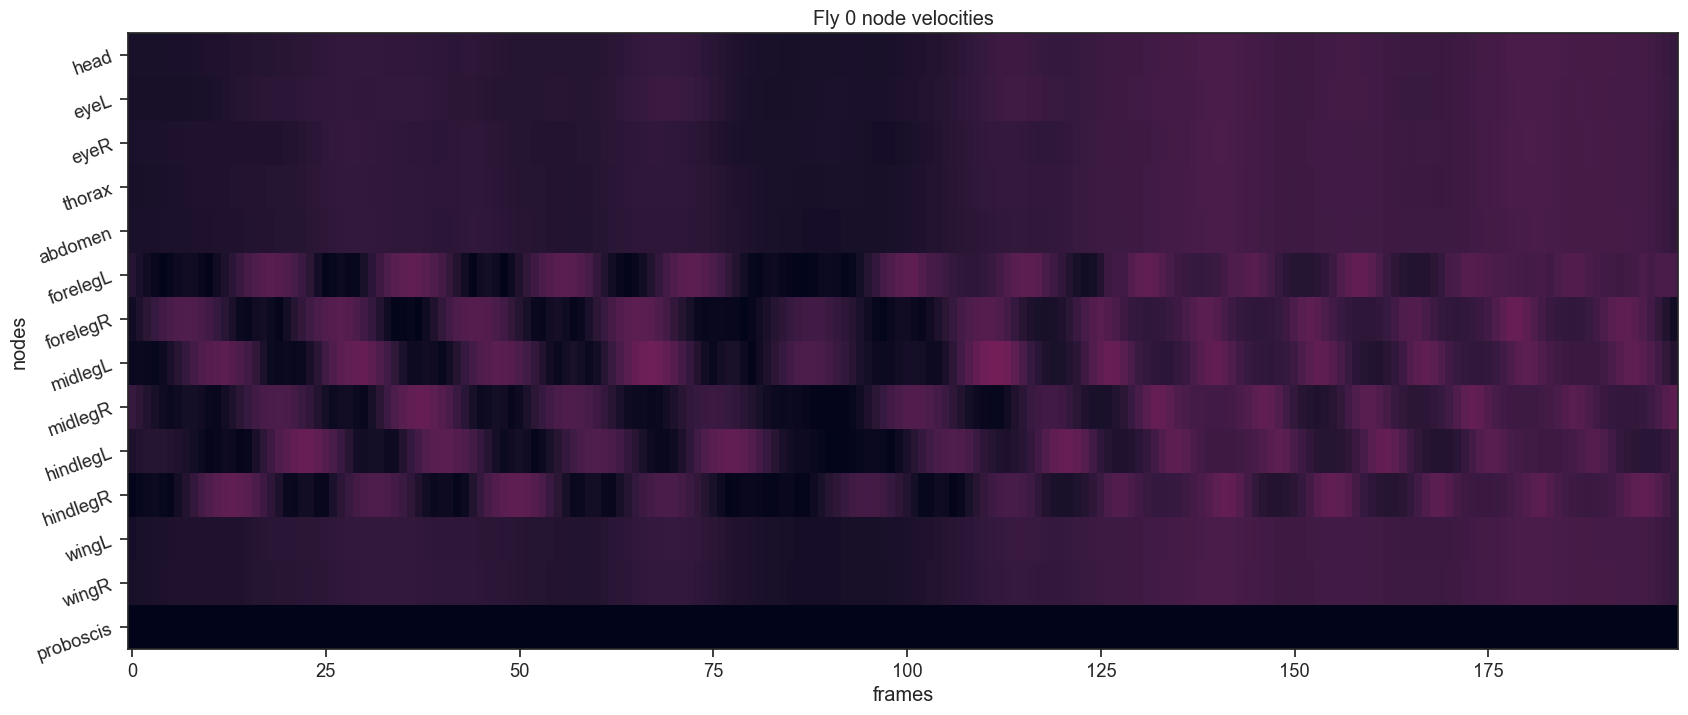

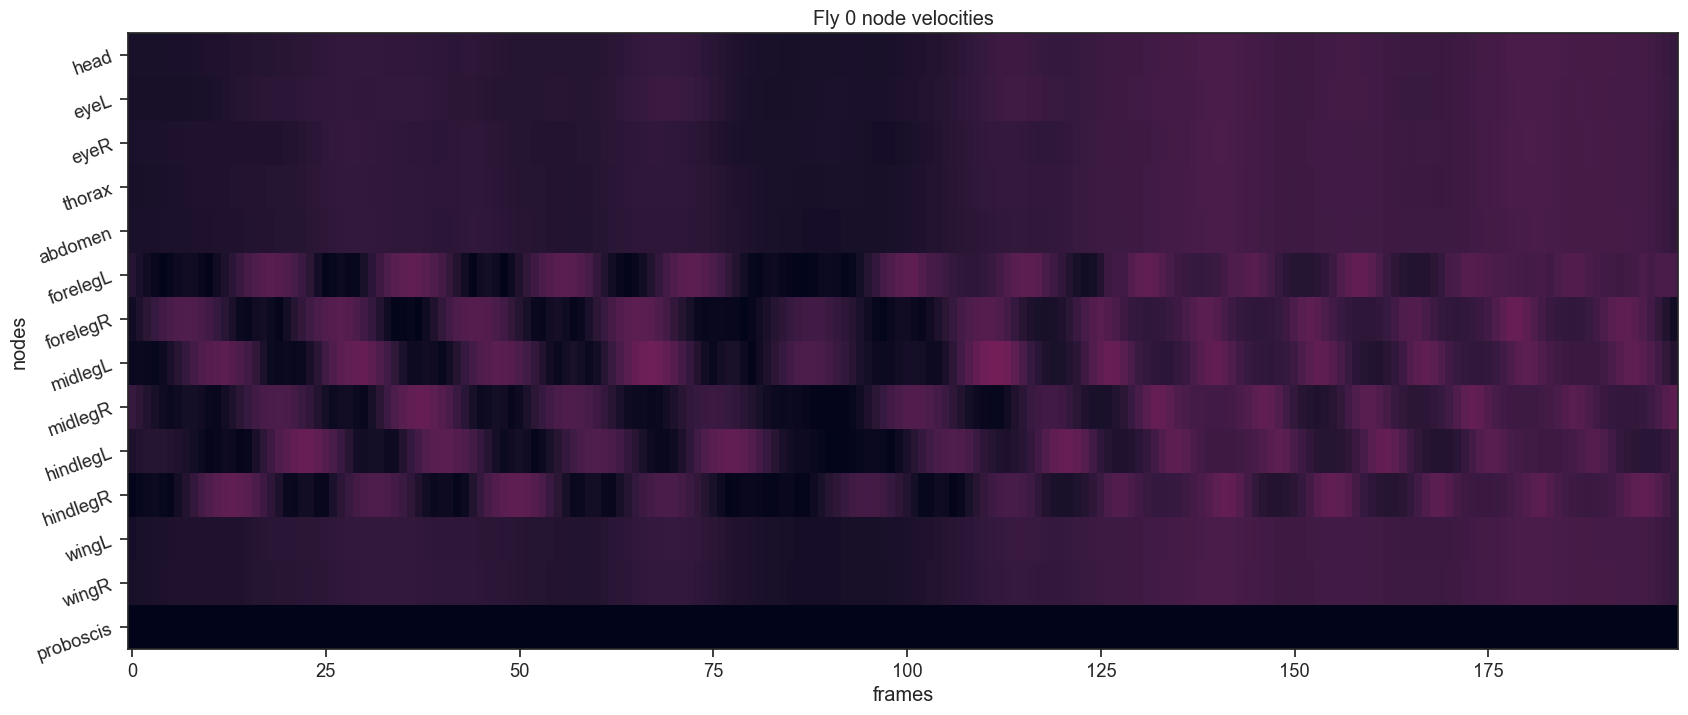

In [68]:
plot_instance_node_velocities(fly_idx, fly_node_velocities[7900200:7900400,:])
plt.show()

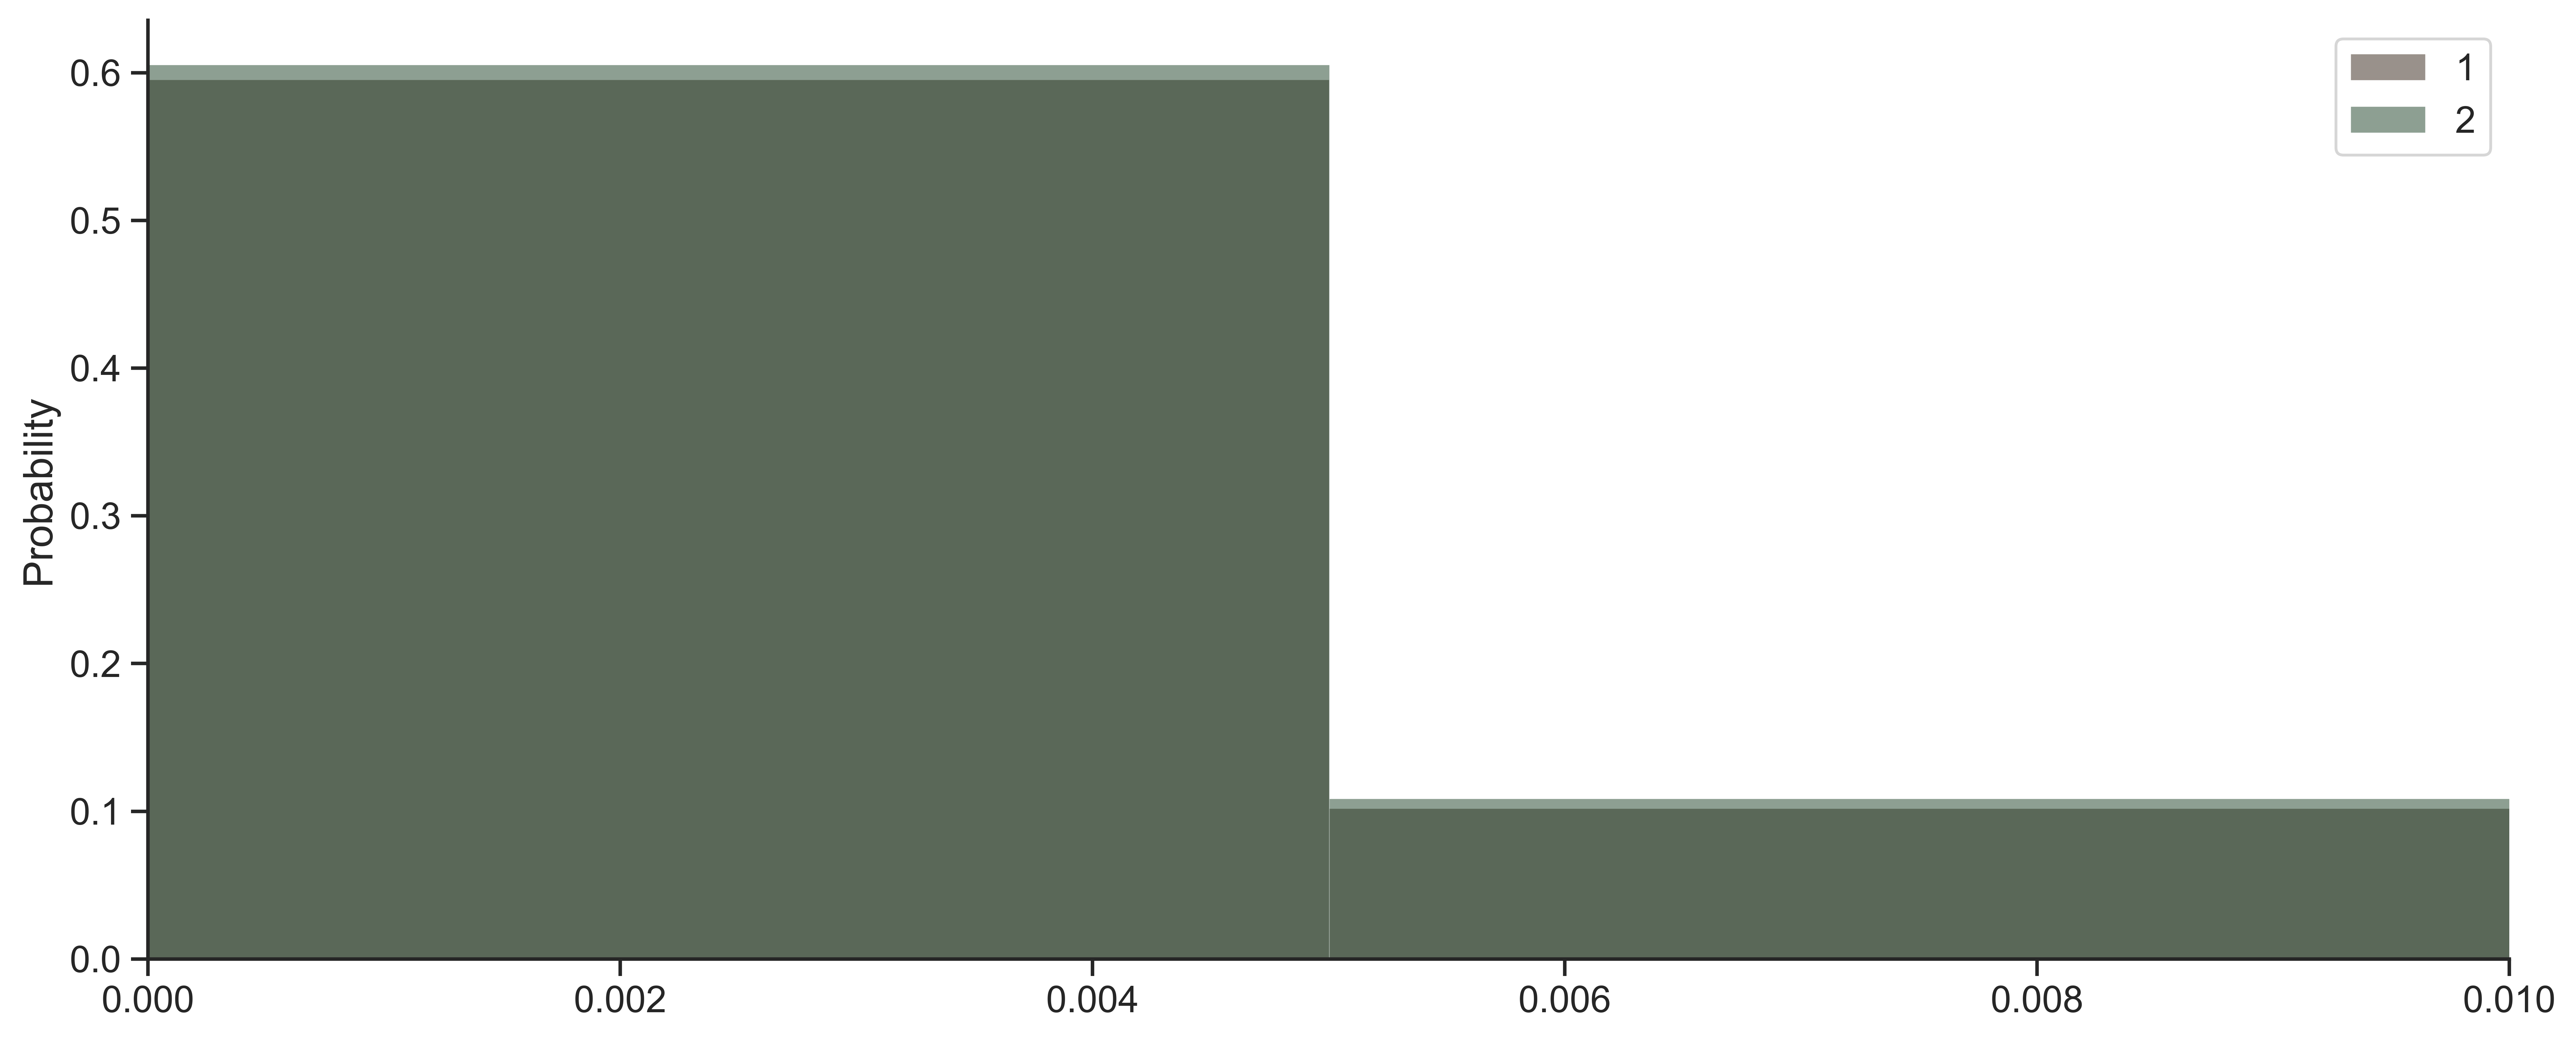

In [203]:
# day = np.concatenate([fly_node_velocities[0:(34020*100),node_names.index('thorax')],fly_node_velocities[(34020*100 + 28800*100):(34020*100 + 28800*100 + 28800*100),node_names.index('thorax')]])

# night = fly_node_velocities[(34020*100):(34020*100 + 28800*100),node_names.index('thorax')]
day = np.concatenate([range(34020*100),range((34020*100 + 28800*100),(34020*100 + 28800*100 + 28800*100))])
night = np.array(range((34020*100),(34020*100 + 28800*100)))
mpl.rcParams['figure.dpi'] =600
fig, ax = plt.subplots()
# for i in range(4):
sns.histplot(np.concatenate([thx_vel[i][day[day < 8999999]] for i in range(4)])[::100],stat="probability",binwidth=.005,alpha = .5, color=palettable.wesanderson.Aquatic1_5.mpl_colors[0]);

sns.histplot(np.concatenate([thx_vel[i][night[night< 8999999]] for i in range(4)])[::100],stat="probability",binwidth=.005,alpha = .5, color=palettable.wesanderson.Aquatic1_5.mpl_colors[1]);

plt.legend(labels=['1',"2", "3","4"])
# plt.xlabel("Thorax Velocity (px)")
plt.xlim(0,0.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()


In [243]:
day_vel = [thx_vel[i][day[day < 8999999]] for i in range(4)]
night_vel = [thx_vel[i][night[night < 8999999]] for i in range(4)]


day_vel2 = [thx_vel[i][day[day < 8999999]] for i in range(4)]
night_vel2 = [thx_vel[i][night[night < 8999999]] for i in range(4)]

print(len(day_vel2[0]))
print(len(night_vel2[0]))

day_vel_lens = [len(day_vel[day_vel > 1])/len(day_vel2[0]) for day_vel in day_vel]
night_vel_lens = [len(night_vel[night_vel > 1])/len(night_vel2[0]) for night_vel in night_vel]

6119999
2880000


/Users/wolf/opt/anaconda3/envs/long-timescale-behavior/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


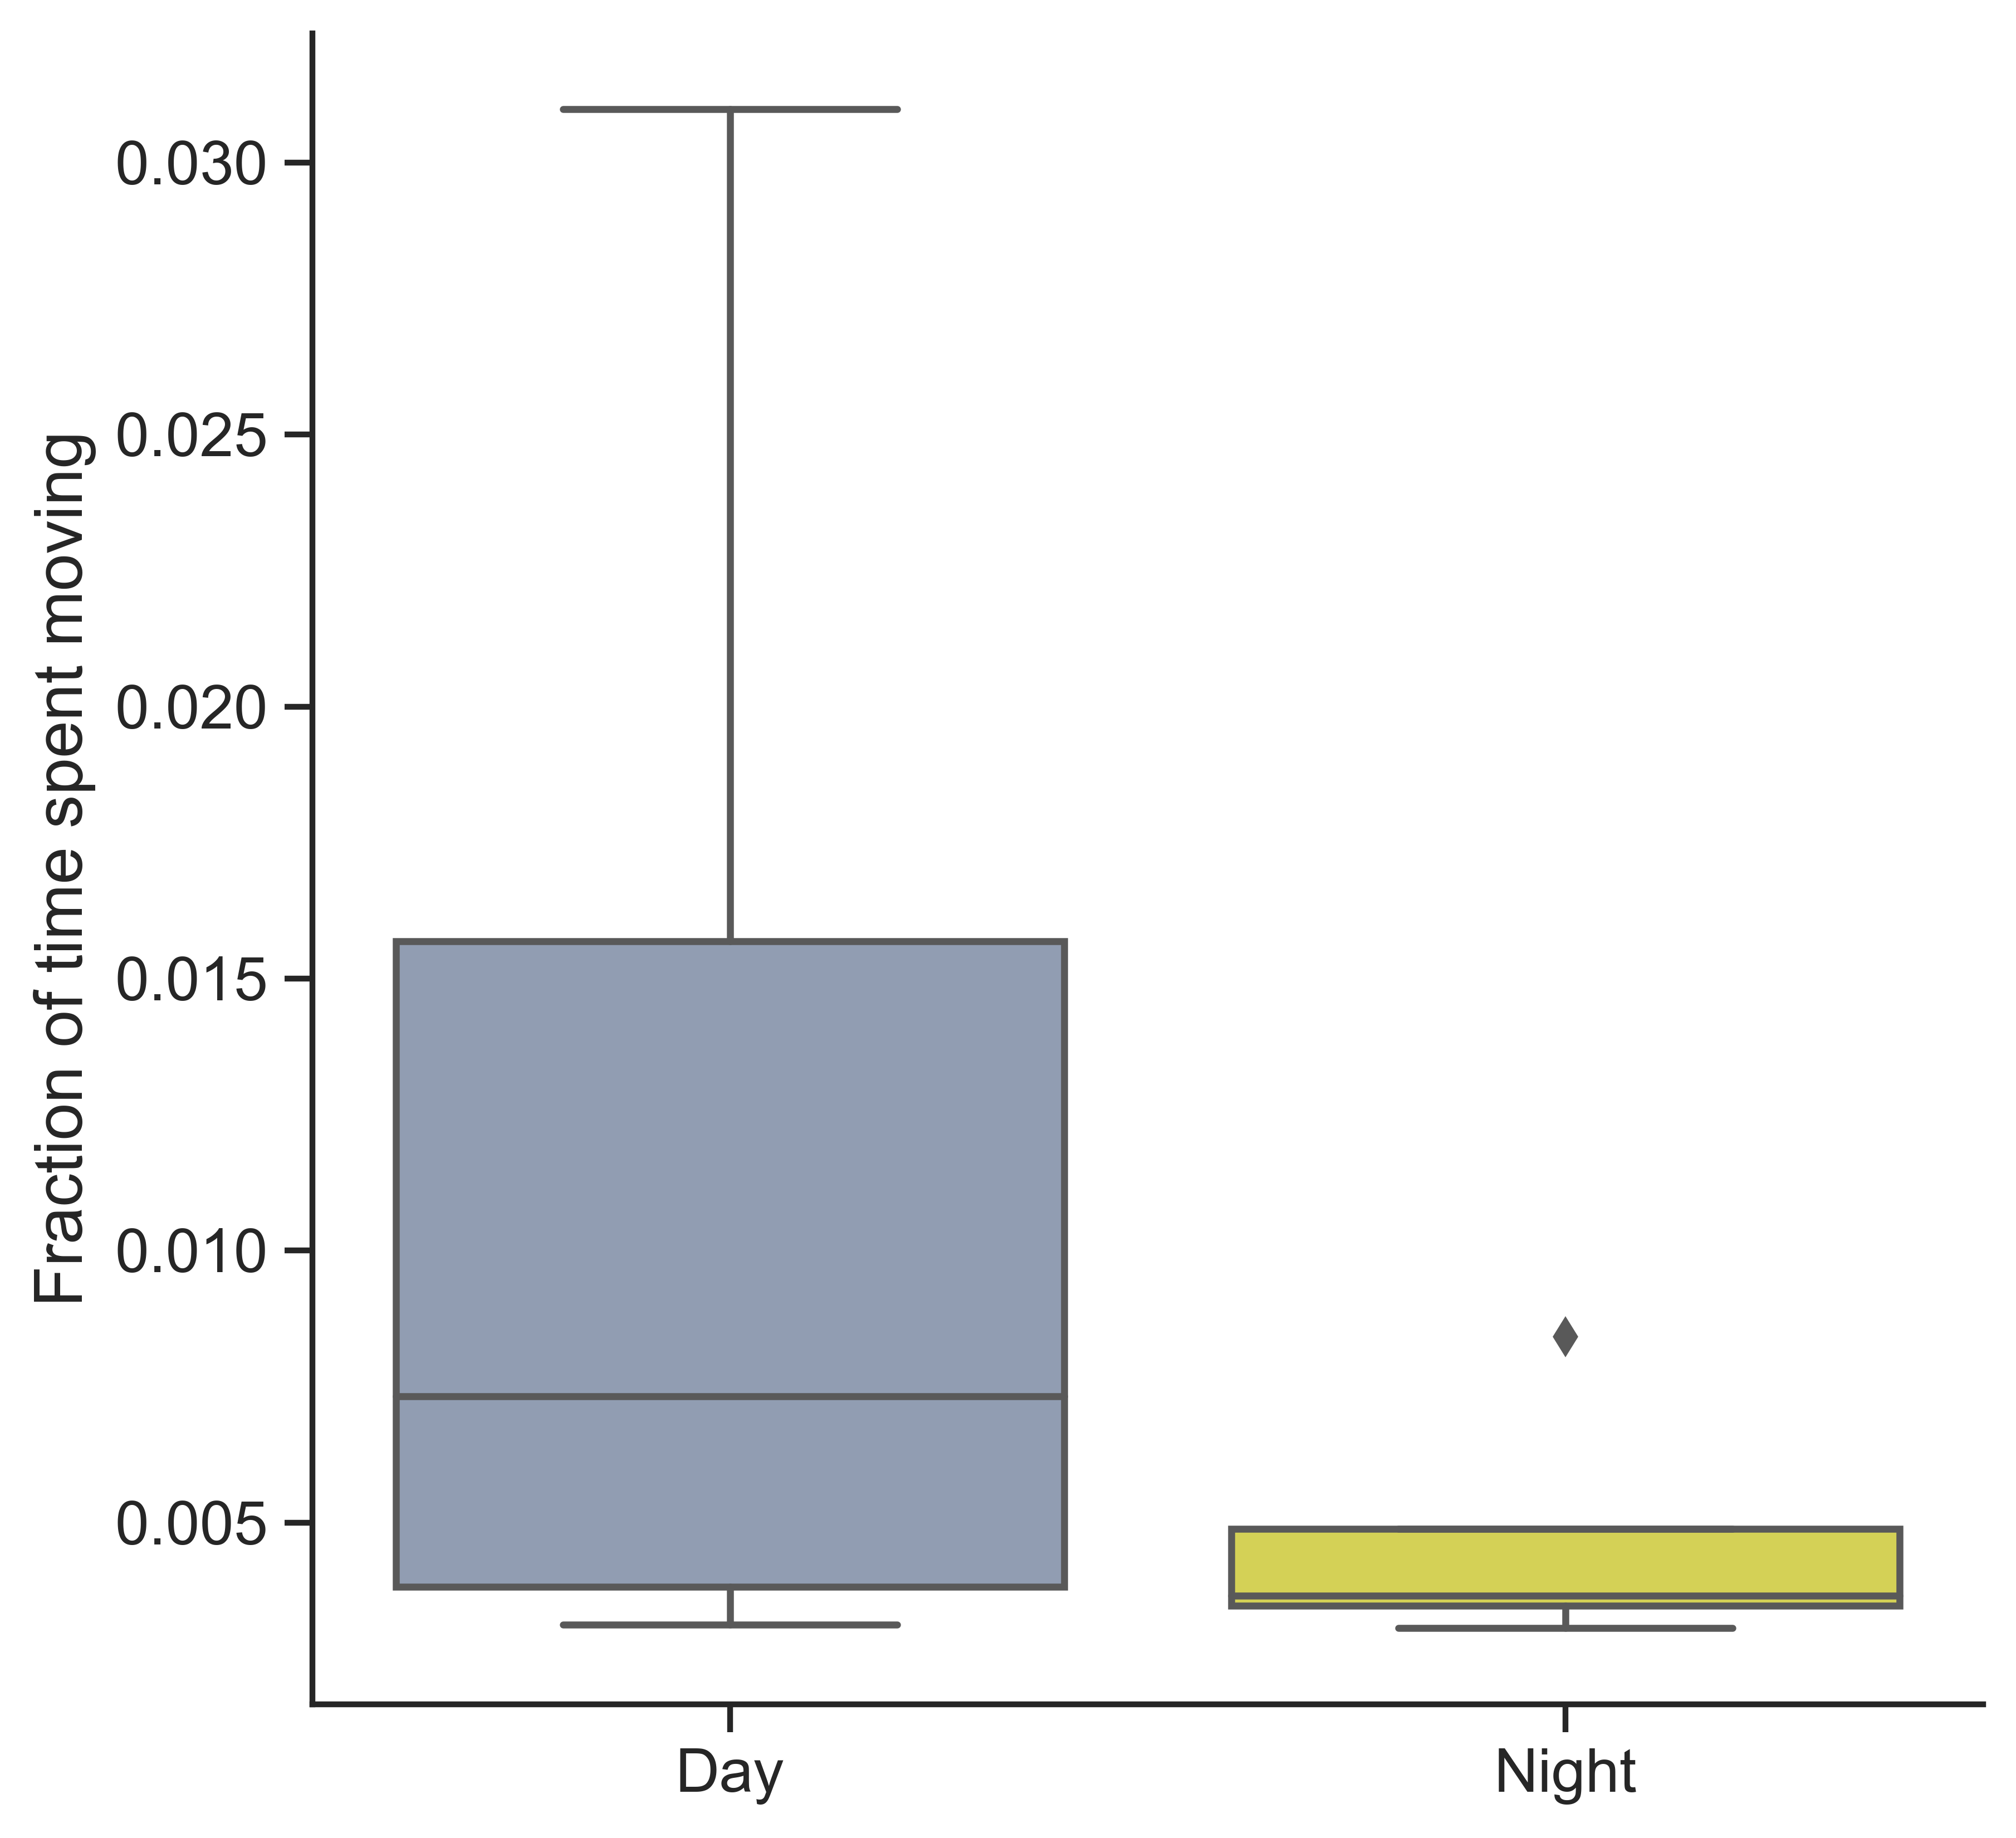

In [248]:
fig, ax = plt.subplots();
# ax = plt.Axes(fig, [0., 0., 1., 1.])
# ax.set_axis_off()
fig.add_axes(ax)
fig.set_size_inches(5, 5, True);
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# ax.axis('off')
fig.patch.set_visible(False)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
sns.boxplot(["Day","Day","Day","Day","Night","Night","Night","Night"], day_vel_lens + night_vel_lens,palette= palettable.wesanderson.Aquatic2_5.mpl_colors)
# sns.swarmplot(["Day","Day","Day","Day","Night","Night","Night","Night"], day_vel_lens + night_vel_lens)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel("Fraction of time spent moving")
plt.show()


In [192]:
d = np.concatenate([thx_vel[i][day[day < 9000000]] for i in range(4)])

In [191]:
np.max(day)

9161999

/Users/wolf/opt/anaconda3/envs/long-timescale-behavior/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


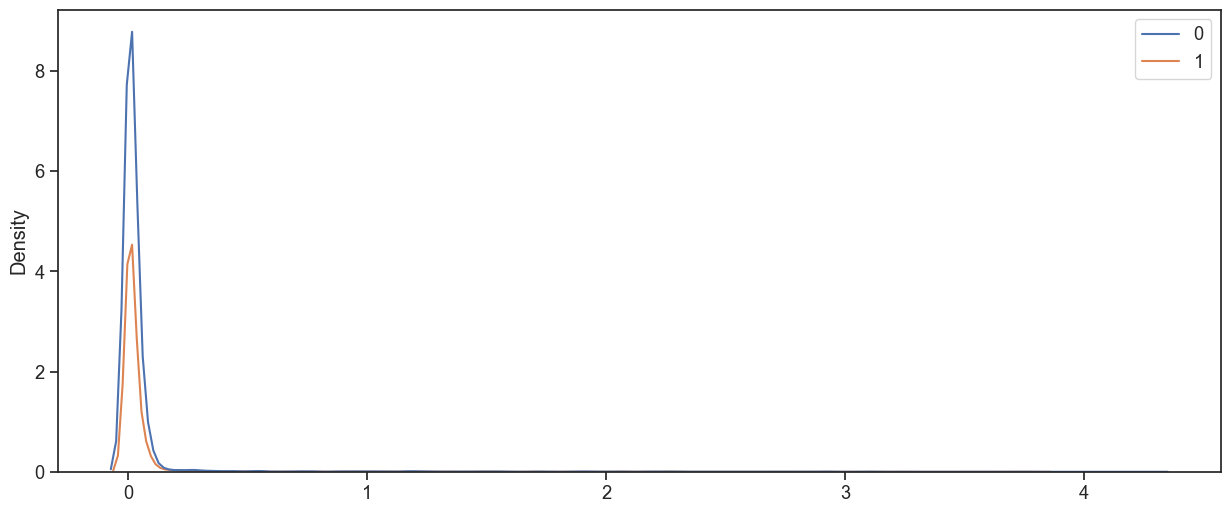

In [110]:
sns.kdeplot(data=[day[::1000],night[::1000]],bw=.1)
plt.show()

In [83]:
day = fly_node_velocities[0:34020*100,node_names.index('thorax')]
day.shape
 

(3402000,)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
nstates = 10

km = KMeans(n_clusters=nstates)

labels = km.fit_predict(fly_node_velocities)

In [ ]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(211)
ax1.imshow(fly_node_velocities.T, aspect="auto", vmin=0, vmax=20, interpolation="nearest")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Nodes")
ax1.set_yticks(np.arange(node_count))
ax1.set_yticklabels(node_names);
ax1.set_title(f"Fly {fly_idx} node velocities")
ax1.set_xlim(0,frame_count)

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.imshow(labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
ax2.set_xlabel("Frames")
ax2.set_yticks([])
ax2.set_title("Ethogram (colors = clusters)");

## More advanced visualizations

For some additional analysis, we'll first smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint.

### Visualizing thorax x-y dynamics and velocity for fly 0

In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thorax_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*thorax_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Thorax')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.imshow(thx_vel_fly0[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

### Visualize thorax colored by magnitude of fly speed

In [ ]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(thorax_loc[:, 0, 0], thorax_loc[:, 1, 0], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Thorax tracks')

kp = thx_vel_fly0  # use thx_vel_fly1 for other fly
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(thorax_loc[:,0,0], thorax_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Thorax tracks colored by magnitude of fly speed')

### Find covariance in thorax velocities between fly-0 and fly-1

In [ ]:
import pandas as pd

def corr_roll(datax, datay, win):
    """
    datax, datay are the two timeseries to find correlations between
    
    win sets the number of frames over which the covariance is computed
    
    """
    
    s1 = pd.Series(datax)
    s2 = pd.Series(datay)
    
    return np.array(s2.rolling(win).corr(s1))

In [ ]:
win = 50

cov_vel = corr_roll(thx_vel_fly0, thx_vel_fly1,win)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
ax[0].plot(thx_vel_fly0, 'y', label='fly-0')
ax[0].plot(thx_vel_fly1, 'g', label='fly-1')
ax[0].legend()
ax[0].set_title('Forward Velocity')

ax[1].plot(cov_vel, 'c', markersize=1)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title('Covariance')

fig.tight_layout()

## Clustering

For an example of clustering the data, we'll

1. extract joint velocities for each joint,
2. run simple k-means on the velocities from each frame.


In [169]:
def instance_node_velocities(fly_node_locations):
    fly_node_velocities = np.zeros((frame_count, node_count))

    for n in range(0, node_count):
        fly_node_velocities[:, n] = smooth_diff(fly_node_locations[:, n, :])
    
    return fly_node_velocities

In [170]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(node_count), node_names, rotation=20);
    plt.title(f'Fly {instance_idx} node velocities')

In [171]:
fly_idx = 0
fly_node_velocities = instance_node_velocities(fly_idx)
plot_instance_node_velocities(fly_idx, fly_node_velocities)

KeyboardInterrupt: 

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
nstates = 10

km = KMeans(n_clusters=nstates)

labels = km.fit_predict(fly_node_velocities)

In [ ]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(211)
ax1.imshow(fly_node_velocities.T, aspect="auto", vmin=0, vmax=20, interpolation="nearest")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Nodes")
ax1.set_yticks(np.arange(node_count))
ax1.set_yticklabels(node_names);
ax1.set_title(f"Fly {fly_idx} node velocities")
ax1.set_xlim(0,frame_count)

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.imshow(labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
ax2.set_xlabel("Frames")
ax2.set_yticks([])
ax2.set_title("Ethogram (colors = clusters)");